In [2]:
import requests
import time
import os
import asyncio
import aiohttp
import nest_asyncio
import base64
import matplotlib.pyplot as plt
import threading
import numpy as np
import pandas as pd

lock = threading.Lock()
# Apply nest_asyncio to allow nested event loops in Jupyter Notebook
nest_asyncio.apply()
%matplotlib inline

# Define constants
MAX_CHUNK_SIZE = 512 * 1024 - 200
anton_base_url = "http://localhost:8021"
bob_base_url = "http://localhost:8031"
data_folder = "data"
DELAY_BETWEEN_GROUPS = 0.01  # Delay in seconds between sending groups of requests

# Helper function to handle responses
async def handle_response(response):
    response.raise_for_status()
    return await response.json()

async def read_and_encode_file(file_path):
    try:
        with open(file_path, 'rb') as file:
            file_content = file.read()
        encoded_content = base64.b64encode(file_content).decode('utf-8')
        return encoded_content
    except Exception as e:
        print(f"Failed to read and encode file {file_path}: {e}")
        return None

def split_into_chunks(encoded_content, chunk_size):
    return [encoded_content[i:i + chunk_size] for i in range(0, len(encoded_content), chunk_size)]

async def send_didcomm_message_async(session, send_message_url, message, latency_list, timestamps, start_time, data_sent):
    try:
        url = send_message_url
        payload = message
        request_time = time.time()
        async with session.post(url, json=payload, headers={"Content-Type": "application/json"}) as response:
            response_time = time.time()
            latency = response_time - request_time
            latency_list.append(latency)
            elapsed_time = response_time - start_time
            timestamps.append(elapsed_time)
            await handle_response(response)
            
            with lock:
                data_sent.append(len(message["attachments"][0]["data"]["base64"]))
    except aiohttp.ClientError as e:
        print(f"Failed to send message: {e}")

def calculate_average_metrics(timestamps, latency_list, data_sent):
    max_time = max(timestamps)
    num_intervals = 10
    interval = max_time / num_intervals

    averaged_timestamps = []
    averaged_latency = []
    averaged_throughput = []

    current_time = 0

    while current_time < max_time:
        next_time = current_time + interval
        interval_latencies = [lat for ts, lat in zip(timestamps, latency_list) if current_time <= ts < next_time]
        interval_data_sent = [ds for ts, ds in zip(timestamps, data_sent) if current_time <= ts < next_time]

        if interval_latencies:
            avg_latency = np.mean(interval_latencies)
        else:
            avg_latency = 0

        if interval_data_sent:
            total_data_sent = sum(interval_data_sent)
            throughput = total_data_sent / interval
        else:
            throughput = 0

        averaged_timestamps.append((current_time + next_time) / 2)
        averaged_latency.append(avg_latency)
        averaged_throughput.append(throughput)

        current_time = next_time

    return averaged_timestamps, averaged_latency, averaged_throughput

async def test_performance(send_message_url, data_folder, parallel_count, num_repeats, route):
    latency_list = []
    data_sent = []
    timestamps = []

    if not os.path.isdir(data_folder):
        print(f"Data folder '{data_folder}' does not exist.")
        return

    encoded_files = []
    for file_name in os.listdir(data_folder):
        file_path = os.path.join(data_folder, file_name)
        if os.path.isfile(file_path):
            encoded_content = await read_and_encode_file(file_path)
            if encoded_content:
                encoded_files.append((file_name, encoded_content))
                print(f"Encoded file: {file_name}, Size: {len(encoded_content)}")

    if not encoded_files:
        print("No files to encode and send.")
        return

    didcomm_message_template = {
        "type": "https://didcomm.org/file-transfer/1.0/message",
        "attachments": []
    }

    start_time = time.time()

    async with aiohttp.ClientSession() as session:
        for _ in range(num_repeats):
            for file_name, encoded_content in encoded_files:
                chunks = split_into_chunks(encoded_content, MAX_CHUNK_SIZE)
                for idx, chunk in enumerate(chunks):
                    tasks = []
                    for _ in range(parallel_count):
                        didcomm_message = didcomm_message_template.copy()
                        didcomm_message["attachments"] = [
                            {
                                "filename": f"{file_name}.part{idx + 1}",
                                "data": {
                                    "base64": chunk
                                }
                            }
                        ]
                        didcomm_message["content"] = f"Sending file {file_name} part {idx + 1}"
                        tasks.append(send_didcomm_message_async(session, send_message_url, didcomm_message, latency_list, timestamps, start_time, data_sent))
                    await asyncio.gather(*tasks)
                    await asyncio.sleep(DELAY_BETWEEN_GROUPS)

        end_time = time.time()

        averaged_timestamps, averaged_latency, averaged_throughput = calculate_average_metrics(timestamps, latency_list, data_sent)
        
        total_average_latency = sum(latency_list) / len(latency_list)
        total_average_throughput = sum(data_sent) / (end_time - start_time)

        total_avg_data = {
            'total_average_latency': [total_average_latency],
            'total_average_throughput': [total_average_throughput],
            'start_time': [start_time],
            'end_time': [end_time]
        }
        total_avg_df = pd.DataFrame(total_avg_data)

        avg_data = {
            'averaged_timestamps': averaged_timestamps,
            'averaged_latency': averaged_latency,
            'averaged_throughput': averaged_throughput
        }
        avg_df = pd.DataFrame(avg_data)

        data = {
            'timestamps': timestamps,
            'latency_list': latency_list,
            'data_sent': data_sent
        }
        original_df = pd.DataFrame(data)

        combined_df = pd.concat([total_avg_df, avg_df, original_df], ignore_index=True)

        combined_df.to_csv(route, index=False)

        plot_metrics(avg_data, data_folder)

def plot_metrics(avg_data, data_folder):
    averaged_timestamps = avg_data['averaged_timestamps']
    averaged_latency = avg_data['averaged_latency']
    averaged_throughput = avg_data['averaged_throughput']

    print(f"Averaged Timestamps for {data_folder}: {averaged_timestamps}")
    print(f"Averaged Latency for {data_folder}: {averaged_latency}")
    print(f"Averaged Throughput for {data_folder}: {averaged_throughput}")

    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Latency (s)', color='tab:blue')
    ax1.plot(averaged_timestamps, averaged_latency, color='tab:blue', label='Latency', marker='o', linestyle='-')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_xlim(left=0, right=max(averaged_timestamps))  # Set x-axis to start at 0 and end at max_time
    ax1.set_ylim(bottom=0)  # Set y-axis to start at 0 for latency

    ax2 = ax1.twinx()
    ax2.set_ylabel('Throughput (bytes/s)', color='tab:orange')
    ax2.plot(averaged_timestamps, averaged_throughput, color='tab:orange', label='Throughput', marker='x', linestyle='-')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax2.set_ylim(bottom=0)  # Set y-axis to start at 0 for throughput

    fig.tight_layout()
    plt.title(f'Performance Metrics for {data_folder}')
    fig.legend(loc='upper left')

    plt.show()
    
async def delete_connection(session, delete_url):
    async with session.delete(delete_url, headers={"Content-Type": "application/json"}) as response:
        status_code = response.status
        print(f"Deleted connection: {delete_url}")
        return status_code

async def fetch_connections(session, url):
    async with session.get(url, headers={"Accept": "application/json"}) as response:
        return await handle_response(response)

async def create_request(session, url):
    async with session.post(url, headers={"Accept": "application/json"}) as response:
        return await handle_response(response)



In [9]:

async def prepare_connections_and_requests():
    async with aiohttp.ClientSession() as session:
        # 1. Get Anton's connections and delete them
        anton_connections_url = f"{anton_base_url}/connections"
        anton_connections_response = await fetch_connections(session, anton_connections_url)
        anton_connections = anton_connections_response["results"]
        
        delete_tasks = []
        for connection in anton_connections:
            connection_id = connection["connection_id"]
            delete_url = f"{anton_base_url}/connections/{connection_id}"
            delete_tasks.append(delete_connection(session, delete_url))
        
        # Await all delete tasks
        await asyncio.gather(*delete_tasks)
    
        # 2. Get Bob's connections
        bob_connections_url = f"{bob_base_url}/connections"
        bob_connections_response = await fetch_connections(session, bob_connections_url)
    
        # 3. Bob sends a connection request to Anton
        bob_create_request_url = f"{bob_base_url}/didexchange/create-request?their_public_did=NyaE9SFSneSNRq6Ch8N9Pt&alias=Anton"
        bob_create_request_response = await create_request(session, bob_create_request_url)
        #bob_connection_id = bob_create_request_response["connection_id"]
    
        # Wait for the connection request to appear in Anton's connections
        await asyncio.sleep(2) 
    
        # 4. Query again (if in different machines, ignore all step 1-3)
        anton_connections_url = f"{anton_base_url}/connections"
        anton_connections_response = await fetch_connections(session, anton_connections_url)
        anton_connections = anton_connections_response["results"]

        bob_connection_id = anton_connections[0]["connection_id"]

        # Set send_message_url
        send_message_url = f"{anton_base_url}/connections/{bob_connection_id}/send-message"
        
        return send_message_url


async def main_prepare():
    try:
        send_message_url = await prepare_connections_and_requests() 
        with open("data/temp/send_message_url.txt", "w") as f:
            f.write(send_message_url)
    except KeyboardInterrupt:
        print("Process interrupted by user")

try:
    asyncio.run(main_prepare())
except KeyboardInterrupt:
    print("Process interrupted by user")



Deleted connection: http://localhost:8021/connections/d3eeaa09-c019-4f35-9f85-92eaa79e0e25
Deleted connection: http://localhost:8021/connections/2eba3bcb-5867-4835-834f-9c49ce4e280a


In [1]:

async def send_test_messages(send_message_url, http_version, network_latency):
    async with aiohttp.ClientSession() as session:
        test_cases = [
            ('data/music', 2, 10),
            ('data/music', 5, 10),
            ('data/music', 10, 10),
            ('data/music', 20, 10),
        ]

        for data_folder, parallel_count, num_repeats in test_cases:
            # Extract data type name from the data folder
            data_type_name = data_folder.split('/')[-1]
            new_route = f"data/performance/{data_type_name}_{http_version}_{parallel_count}_{num_repeats}_{network_latency}ms.sh"
            await test_performance(send_message_url, data_folder, parallel_count, num_repeats, new_route)


async def main_send():
    try:
        # Read the URL from the file
        with open("data/temp/send_message_url.txt", "r") as f:
            send_message_url = f.read().strip()
        

        http_version = "http1_ssl"
        network_latency = 0  # in milliseconds
        
        await send_test_messages(send_message_url, http_version, network_latency)
    except KeyboardInterrupt:
        print("Process interrupted by user")

try:
    asyncio.run(main_send())
except KeyboardInterrupt:
    print("Process interrupted by user")


NameError: name 'asyncio' is not defined

Encoded file: hello.txt, Size: 16
Averaged Timestamps for data/text: [0.14194035530090332, 0.42582106590270996, 0.7097017765045166, 0.9935824871063232, 1.2774631977081299, 1.5613439083099365, 1.8452246189117432, 2.12910532951355, 2.4129860401153564, 2.696866750717163]
Averaged Latency for data/text: [0.031964778900146484, 0, 0, 0, 0, 0, 0, 0.5248561455653264, 0.06018300056457519, 0.07054518163204193]
Averaged Throughput for data/text: [112.72340389793412, 0, 0, 0, 0, 0, 0, 732.7021253365718, 845.4255292345059, 901.787231183473]


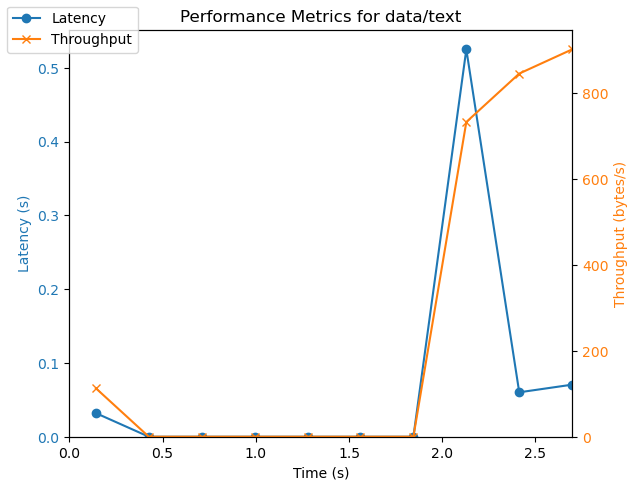

Encoded file: group.jpg, Size: 135104
Averaged Timestamps for data/picture: [0.142556893825531, 0.427670681476593, 0.712784469127655, 0.9978982567787169, 1.283012044429779, 1.568125832080841, 1.8532396197319032, 2.138353407382965, 2.4234671950340276, 2.7085809826850893]
Averaged Latency for data/picture: [0.007851362228393555, 0, 0, 0, 0, 0, 0, 0.7335671053992378, 0.07177935148540296, 0.05374171733856201]
Averaged Throughput for data/picture: [947719.8637994158, 0, 0, 0, 0, 0, 0, 4264739.387097371, 9003338.70609445, 9477198.637994157]


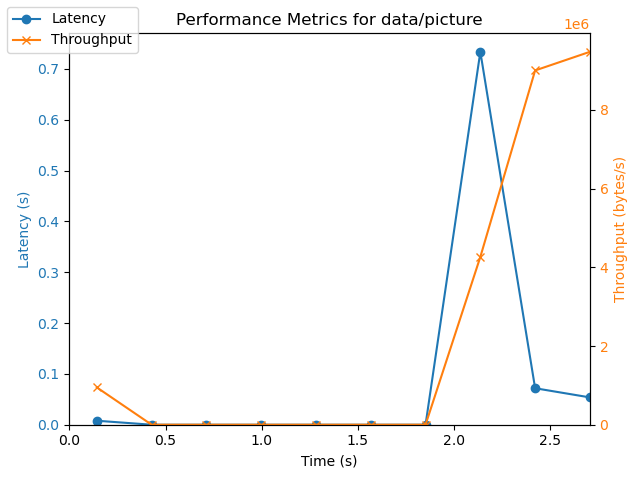

Encoded file: cinematic-rythmline.mp3, Size: 3993600
Averaged Timestamps for data/music: [0.42142295837402344, 1.2642688751220703, 2.107114791870117, 2.949960708618164, 3.792806625366211, 4.635652542114258, 5.478498458862305, 6.321344375610352, 7.164190292358398, 8.007036209106445]
Averaged Latency for data/music: [0.019519567489624023, 0, 0.23148636384443802, 0.05363954197276722, 0.05781327724456787, 0.05544954776763916, 0.056418379870328036, 0.0568784236907959, 0.06021639823913574, 0.052984661526150174]
Averaged Throughput for data/music: [1243615.2079186412, 0, 20519650.930657577, 31837135.90680118, 29909239.0424853, 29909239.0424853, 31837135.90680118, 29909239.0424853, 29909239.0424853, 31451556.533938]


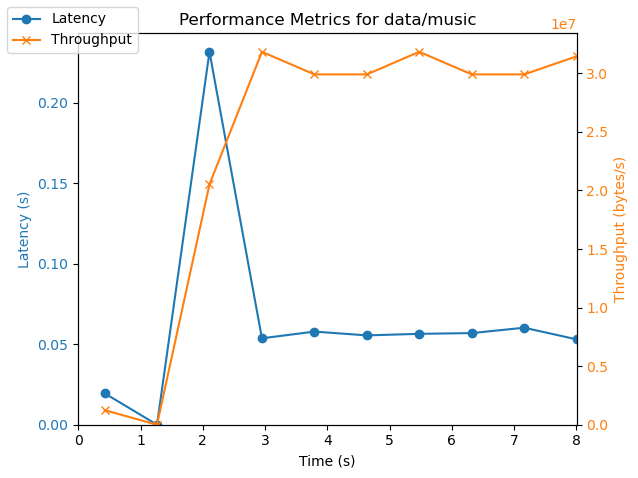

Encoded file: sample_video.mp4, Size: 18735404
Averaged Timestamps for data/video: [1.6298149824142456, 4.889444947242737, 8.149074912071228, 11.40870487689972, 14.66833484172821, 17.9279648065567, 21.187594771385193, 24.447224736213684, 27.706854701042175, 30.966484665870667]
Averaged Latency for data/video: [0.1333217716217041, 0.05361934057096156, 0.05346271991729736, 0.060242463671971884, 0.05931352445592431, 0.0609566237475421, 0.058261171547142235, 0.05726637299527827, 0.057124962981458735, 0.061189721459927765]
Averaged Throughput for data/video: [12058608.008921085, 32758080.25823517, 31954173.05764043, 30185577.216332003, 30507140.0965699, 29542451.455856215, 29542451.455856215, 30989484.416926745, 30507140.0965699, 29219978.04281796]


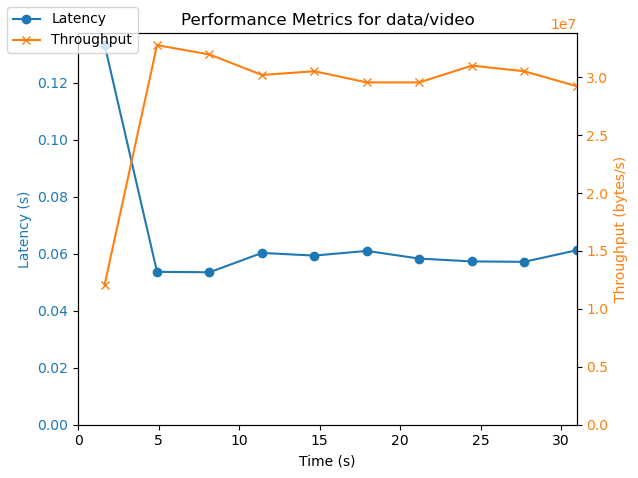

In [15]:

async def send_test_messages(send_message_url, http_version, network_latency):
    async with aiohttp.ClientSession() as session:
        test_cases = [
            ('data/text', 5, 10),
            ('data/picture', 5, 10),
            ('data/music', 5, 10),
            ('data/video', 5, 10),
        ]

        for data_folder, parallel_count, num_repeats in test_cases:
            # Extract data type name from the data folder
            data_type_name = data_folder.split('/')[-1]
            new_route = f"data/performance/{data_type_name}_{http_version}_{parallel_count}_{num_repeats}_{network_latency}ms.sh"
            await test_performance(send_message_url, data_folder, parallel_count, num_repeats, new_route)

async def main_send():
    try:
        with open("data/temp/send_message_url.txt", "r") as f:
            send_message_url = f.read().strip()
        
        http_version = "http1"
        network_latency = 0  # in milliseconds
        
        await send_test_messages(send_message_url, http_version, network_latency)
    except KeyboardInterrupt:
        print("Process interrupted by user")

try:
    asyncio.run(main_send())
except KeyboardInterrupt:
    print("Process interrupted by user")
